In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from psiam_tied_no_dv_map_utils import psiam_tied_data_gen_wrapper, up_RTs_fit_single_t_fn, down_RTs_fit_single_t_fn, up_RTs_fit_fn, down_RTs_fit_fn
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.integrate import trapezoid as trapz
from scipy.integrate import quad


# data tachometric?

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

In [3]:
df_led_off = df[ df['LED_trial'] == 0 ]
df_led_off_valid = df_led_off[ df_led_off['timed_fix'] > df_led_off['intended_fix'] ]

In [4]:
# add rt_wrt_stim
df_led_off_valid.loc[:, "rt_wrt_stim"] = df_led_off_valid["timed_fix"] - df_led_off_valid["intended_fix"]


/tmp/ipykernel_1094926/228101680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_led_off_valid.loc[:, "rt_wrt_stim"] = df_led_off_valid["timed_fix"] - df_led_off_valid["intended_fix"]


In [5]:
# remove rows where response_poke is nan
df_led_off_valid = df_led_off_valid.dropna(subset=['response_poke'])

In [6]:
# add correct
df_led_off_valid = df_led_off_valid.copy()

# Creating the "correct" column based on the given condition
df_led_off_valid["correct"] = ((df_led_off_valid["ILD"] * (2 * df_led_off_valid["response_poke"] - 5)) > 0).astype(int)

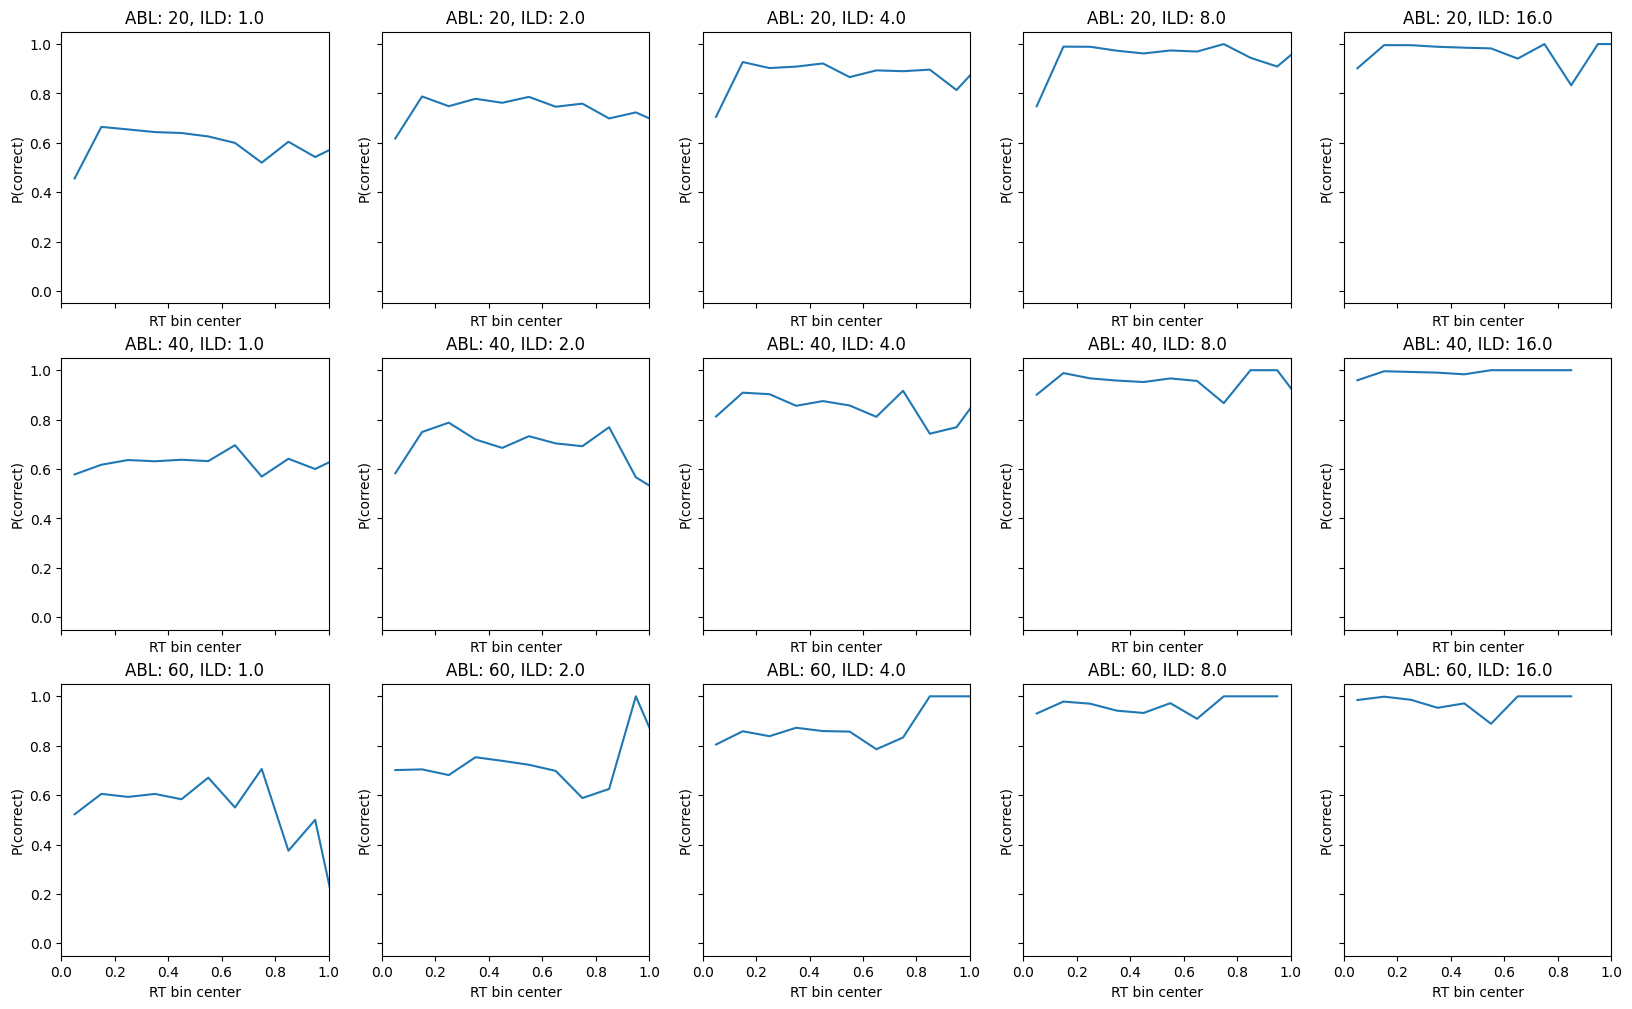

In [7]:
bin_size = 0.1

bin_edges = np.arange(0, df_led_off_valid["rt_wrt_stim"].max() + bin_size, bin_size)
df_led_off_valid["rt_bin"] = pd.cut(df_led_off_valid["rt_wrt_stim"], bins=bin_edges, labels=False) 

# Compute bin centers
bin_centers = bin_edges[:-1] + bin_size / 2

# Group ILDs by their absolute values
df_led_off_valid["abs_ILD"] = df_led_off_valid["ILD"].abs()

# Get unique stimulus conditions (3 ABLs × 5 absolute ILDs)
stim_conditions = df_led_off_valid.groupby(["ABL", "abs_ILD"])

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Iterate over stimulus conditions and plot
for i, ((ABL, abs_ILD), group) in enumerate(stim_conditions):
    # Group by RT bins and compute probability of correct responses
    prob_correct = group.groupby("rt_bin")["correct"].mean()

    # Map bin indices to actual bin centers
    x_vals = bin_centers[: len(prob_correct)]
    
    # Plot
    axes[i].plot(x_vals, prob_correct.values, linestyle="-")
    axes[i].set_title(f"ABL: {ABL}, ILD: {abs_ILD}")
    axes[i].set_xlabel("RT bin center")
    axes[i].set_ylabel("P(correct)")
    axes[i].set_xlim(0, 1)
    # axes[i].axvline(40*1e-3, alpha=0.3)
    # axes[i].grid(True)

# Adjust layout
# plt.tight_layout()
plt.show()


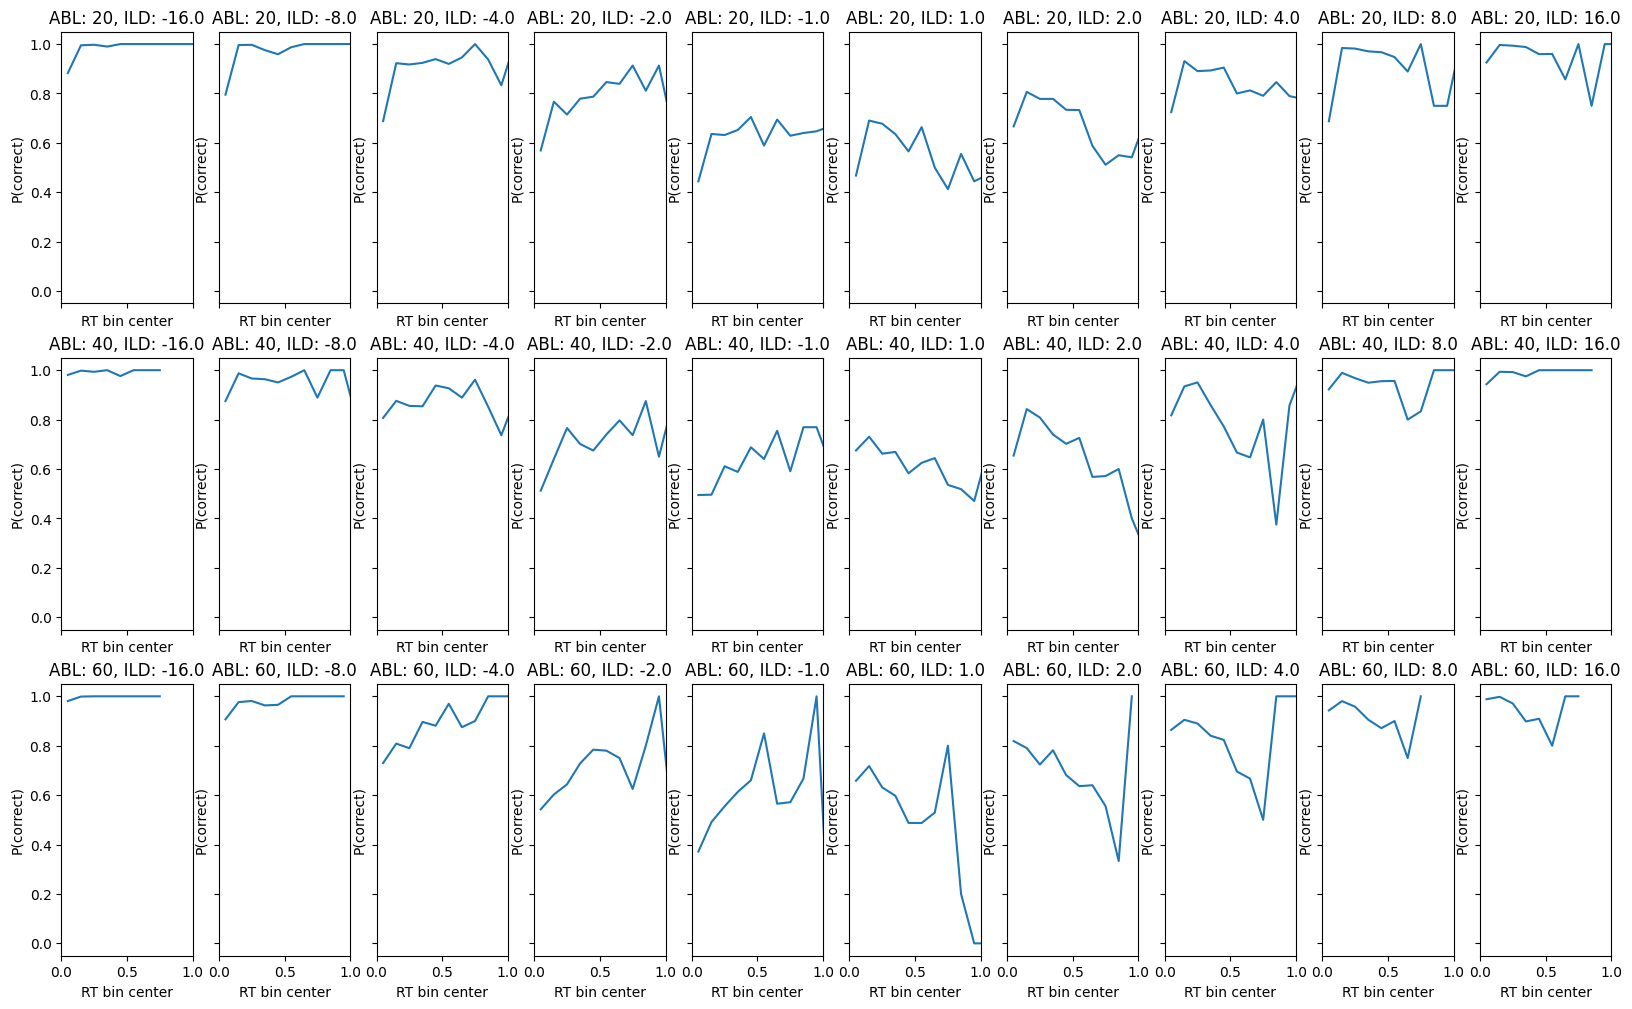

In [8]:
bin_size = 0.1

bin_edges = np.arange(0, df_led_off_valid["rt_wrt_stim"].max() + bin_size, bin_size)
df_led_off_valid["rt_bin"] = pd.cut(df_led_off_valid["rt_wrt_stim"], bins=bin_edges, labels=False) 

# Compute bin centers
bin_centers = bin_edges[:-1] + bin_size / 2

# Group ILDs by their absolute values
# df_led_off_valid["abs_ILD"] = df_led_off_valid["ILD"].abs()

# Get unique stimulus conditions (3 ABLs × 5 absolute ILDs)
stim_conditions = df_led_off_valid.groupby(["ABL", "ILD"])

# Create subplots
fig, axes = plt.subplots(3, 10, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Iterate over stimulus conditions and plot
for i, ((ABL, abs_ILD), group) in enumerate(stim_conditions):
    # Group by RT bins and compute probability of correct responses
    prob_correct = group.groupby("rt_bin")["correct"].mean()

    # Map bin indices to actual bin centers
    x_vals = bin_centers[: len(prob_correct)]
    
    # Plot
    axes[i].plot(x_vals, prob_correct.values, linestyle="-")
    axes[i].set_title(f"ABL: {ABL}, ILD: {abs_ILD}")
    axes[i].set_xlabel("RT bin center")
    axes[i].set_ylabel("P(correct)")
    axes[i].set_xlim(0, 1)
    # axes[i].axvline(40*1e-3, alpha=0.3)
    # axes[i].grid(True)

# Adjust layout
# plt.tight_layout()
plt.show()


# sims

In [9]:
# psiam_tied_data_gen_wrapper(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda,\
#  T_0, theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt)

V_A  = 1.6
theta_A = 2.2
rate_lambda = 0.1
T_0 = 0.1 * 1e-3
theta_E = 40
t_A_aff = -220  * 1e-3
t_E_aff = 30 * 1e-3
t_motor = 40 * 1e-3
dt = 1e-4


# tacho theory

/tmp/ipykernel_1094926/3112407291.py:14: RuntimeWarning: invalid value encountered in scalar divide
  tacho[ti] = p_up / (p_up + p_down)


Text(0.5, 1.0, 'for stim time = 0.25, ABL = 40, ILD = 3')

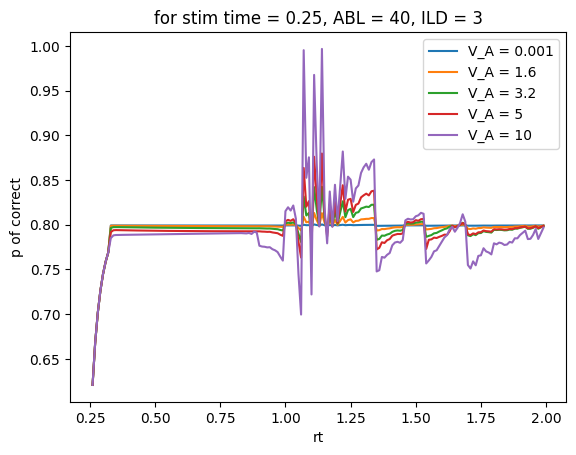

In [10]:
V_A_vals = [0.001, 1.6, 3.2, 5, 10]
ABL = 40
ILD = 3
t_stim = 0.25
K_max = 10
Z_E = 0
bin_size = 0.01
for idx,V_A in enumerate(V_A_vals):
    t_pts = np.arange(0, 2, bin_size)
    tacho = np.zeros_like(t_pts)
    for ti, t in enumerate(t_pts):
        p_up = up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        p_down = down_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
        tacho[ti] = p_up / (p_up + p_down)

    
    plt.plot(t_pts, tacho, label=f'V_A = {V_A}')

plt.legend()
plt.xlabel('rt')
plt.ylabel('p of correct')
plt.title(f'for stim time = {t_stim}, ABL = {ABL}, ILD = {ILD}')
# plt.xlim(0,1)

# theory check

Simulating for V_A = 1.6


  0%|          | 0/1000000 [00:00<?, ?it/s]

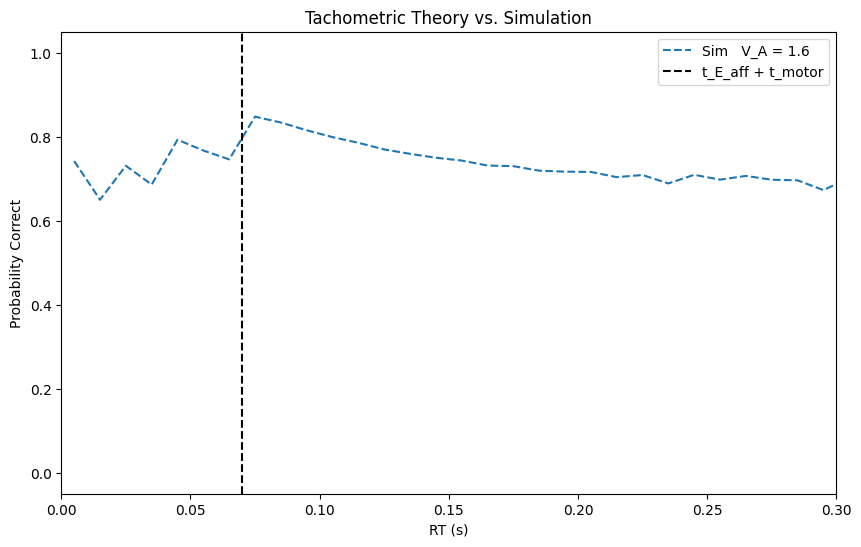

In [11]:
V_A_vals = [1.6]
ABL = 40
ILD = 4
t_stim = 0.25
K_max = 10
Z_E = 0
bin_size = 0.01


ABL_arr = [ABL]
ILD_arr = [1, 2, 4, 8]
t_stim_arr = [t_stim]

# Generate Simulation Results for each V_A
N_sim = int(1e6)
sim_results_dict = {}

for V_A in V_A_vals:
    print(f'Simulating for V_A = {V_A}')
    sim_results = Parallel(n_jobs=10)(
        delayed(psiam_tied_data_gen_wrapper)(
            V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0,
            theta_E, Z_E, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt
        ) 
        for _ in tqdm(range(N_sim))
    )
    # Filter 
    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_df = pd.DataFrame(sim_results_valid)
    sim_results_dict[V_A] = sim_results_valid_df

# Plot everything (theory + simulation) on a single figure
plt.figure(figsize=(10, 6))

for V_A in V_A_vals:
    sim_df = sim_results_dict[V_A].copy()
    # Define correctness
    sim_df['correct'] = (sim_df['ILD'] * sim_df['choice'] > 0).astype(int)
    # rt relative to stimulus onset
    sim_df['rt_wrt_stim'] = sim_df['rt'] - sim_df['t_stim']

    # Bin and compute fraction correct
    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2

    prob_correct = []
    for b_low, b_high in zip(bins[:-1], bins[1:]):
        mask = (sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)
        # Mean of 'correct' in this bin
        corr_mean = sim_df.loc[mask, 'correct'].mean()
        prob_correct.append(corr_mean)

    # Plot simulation curve (use '--' or markers to distinguish)
    plt.plot(
        bin_centers,
        prob_correct,
        '--',
        label=f"Sim   V_A = {V_A}"
    )
    plt.axvline(t_E_aff + t_motor, color='black', linestyle='--', label='t_E_aff + t_motor')

plt.xlabel("RT (s)")
plt.ylabel("Probability Correct")
plt.title("Tachometric Theory vs. Simulation")
plt.legend()
plt.xlim(0,0.3)
plt.show()


# theory check

/tmp/ipykernel_1094926/2061842074.py:21: RuntimeWarning: Mean of empty slice
  tacho_theory_mean = np.nanmean(tacho_all_ILD, axis=0)


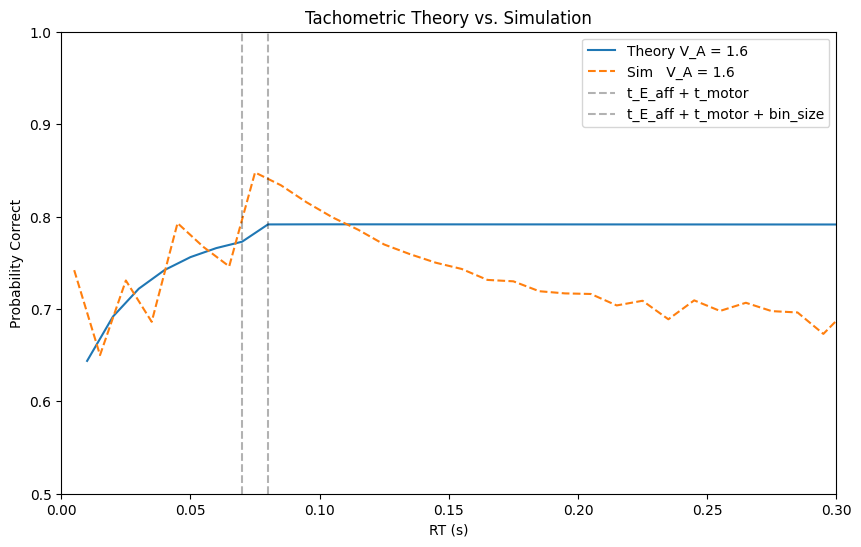

In [12]:
bin_size = 0.01
plt.figure(figsize=(10, 6))

for V_A in V_A_vals:
    t_pts = np.arange(0, 2, bin_size)
    tacho_all_ILD = np.zeros((len(ILD_arr), len(t_pts)))

    for ILD_idx, ILD in enumerate(ILD_arr):
        for i, t in enumerate(t_pts):
            p_up = up_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                        T_0, theta_E, Z_E, t_stim,
                                        t_A_aff, t_E_aff, t_motor, K_max)
            p_down = down_RTs_fit_single_t_fn(t, V_A, theta_A, ABL, ILD, rate_lambda,
                                            T_0, theta_E, Z_E, t_stim,
                                            t_A_aff, t_E_aff, t_motor, K_max)
            # Probability of correct is p_up / (p_up + p_down)
            denom = p_up + p_down
            tacho_all_ILD[ILD_idx, i] = p_up / denom if denom != 0 else np.nan


    tacho_theory_mean = np.nanmean(tacho_all_ILD, axis=0)
    # Plot theoretical curve
    plt.plot(
        t_pts - t_stim,
        tacho_theory_mean,
        label=f"Theory V_A = {V_A}"
    )

    sim_df = sim_results_dict[V_A].copy()
    # Define correctness
    sim_df['correct'] = (sim_df['ILD'] * sim_df['choice'] > 0).astype(int)
    # rt relative to stimulus onset
    sim_df['rt_wrt_stim'] = sim_df['rt'] - sim_df['t_stim']

    # Bin and compute fraction correct
    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2

    prob_correct = []
    for b_low, b_high in zip(bins[:-1], bins[1:]):
        mask = (sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)
        # Mean of 'correct' in this bin
        corr_mean = sim_df.loc[mask, 'correct'].mean()
        prob_correct.append(corr_mean)

    # Plot simulation curve (use '--' or markers to distinguish)
    plt.plot(
        bin_centers,
        prob_correct,
        '--',
        label=f"Sim   V_A = {V_A}"
    )

    plt.axvline(t_E_aff + t_motor, color='black', linestyle='--', label='t_E_aff + t_motor', alpha=0.3)
    plt.axvline(t_E_aff + t_motor + bin_size, color='black', linestyle='--', label='t_E_aff + t_motor + bin_size', alpha=0.3)


plt.xlabel("RT (s)")
plt.ylabel("Probability Correct")
plt.title("Tachometric Theory vs. Simulation")
plt.legend()
plt.xlim(0,0.3)
plt.ylim(0.5, 1)
plt.show()


# weighted average

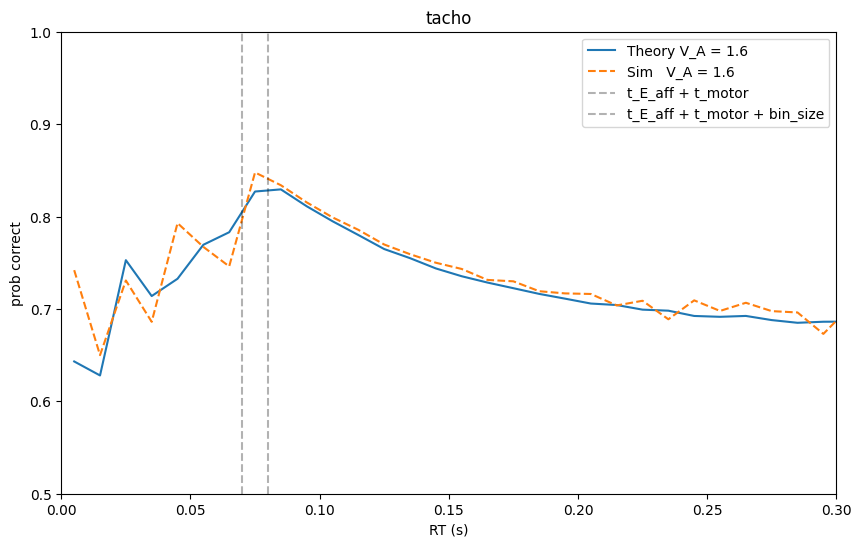

In [13]:
bin_size = 0.01
plt.figure(figsize=(10, 6))

for V_A in V_A_vals:
    t_pts = np.arange(0, 2, bin_size)
    tacho_all_ILD = np.zeros((len(ILD_arr), len(t_pts)))

    for ILD_idx, ILD in enumerate(ILD_arr):
        for i, t in enumerate(t_pts):
            p_up = up_RTs_fit_single_t_fn(
                t, V_A, theta_A, ABL, ILD, rate_lambda,
                T_0, theta_E, Z_E, t_stim,
                t_A_aff, t_E_aff, t_motor, K_max
            )
            p_down = down_RTs_fit_single_t_fn(
                t, V_A, theta_A, ABL, ILD, rate_lambda,
                T_0, theta_E, Z_E, t_stim,
                t_A_aff, t_E_aff, t_motor, K_max
            )
            denom = p_up + p_down
            tacho_all_ILD[ILD_idx, i] = p_up / denom if denom != 0 else np.nan

    sim_df = sim_results_dict[V_A].copy()
    sim_df['correct'] = (sim_df['ILD'] * sim_df['choice'] > 0).astype(int)
    sim_df['rt_wrt_stim'] = sim_df['rt'] - sim_df['t_stim']

    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size / 2

    theory_weighted = []   

    for b_low, b_high in zip(bins[:-1], bins[1:]):
        bin_data = sim_df[(sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)]
        if len(bin_data) == 0:
            theory_weighted.append(np.nan)
        else:
            total_in_bin = len(bin_data)
            bin_weights = []
            for ILD in ILD_arr:
                ild_count = len(bin_data[bin_data['ILD'] == ILD])
                bin_weights.append(ild_count / total_in_bin)
            bin_weights = np.array(bin_weights)

            bin_center = 0.5 * (b_low + b_high)  # RT wrt stim
            t_abs = bin_center + t_stim
            i_theory = int(round(t_abs / bin_size))

            if 0 <= i_theory < len(t_pts):
                theory_ild_values = tacho_all_ILD[:, i_theory]
                weighted_theory = np.sum(theory_ild_values * bin_weights)
                theory_weighted.append(weighted_theory)
            else:
                theory_weighted.append(np.nan)

    plt.plot(bin_centers, theory_weighted, label=f"Theory V_A = {V_A}")
    
    rt_max = sim_df['rt_wrt_stim'].max()
    bins = np.arange(0, rt_max + bin_size, bin_size)
    bin_centers = bins[:-1] + bin_size/2
    prob_correct = []
    for b_low, b_high in zip(bins[:-1], bins[1:]):
        mask = (sim_df['rt_wrt_stim'] >= b_low) & (sim_df['rt_wrt_stim'] < b_high)
        corr_mean = sim_df.loc[mask, 'correct'].mean()
        prob_correct.append(corr_mean)

    plt.plot(
        bin_centers,
        prob_correct,
        '--',
        label=f"Sim   V_A = {V_A}"
    )
    
    plt.axvline(t_E_aff + t_motor, color='black', linestyle='--',
                label='t_E_aff + t_motor', alpha=0.3)
    plt.axvline(t_E_aff + t_motor + bin_size, color='black', linestyle='--',
                label='t_E_aff + t_motor + bin_size', alpha=0.3)

plt.xlabel("RT (s)")
plt.ylabel("prob correct")
plt.title("tacho")
plt.legend()
plt.xlim(0, 0.3)
plt.ylim(0.5, 1)
plt.show()


# P up vs P down

In [ ]:
ILD = 3
p_up_t_pts = up_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
p_down_t_pts = down_RTs_fit_fn(t_pts, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)

plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(p_up_t_pts, p_down_t_pts)
plt.xlabel('p up vs t')
plt.ylabel('p down vs t')

plt.subplot(1,2,2)
plt.plot(t_pts, p_up_t_pts/p_down_t_pts)
plt.xlabel('t')
plt.ylabel('p up / p down')
# plot y = x line
# plt.plot([0, 1], [0, 1], 'k--')

# simulation

In [ ]:
V_A_vals = [0, 10]
sim_results_dict = {}

N_sim = int(100e3)
for V_A in V_A_vals:
    print(f'V_A = {V_A}')
    sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda,\
        T_0, theta_E, 0, t_stim_arr, t_A_aff, t_E_aff, t_motor, dt) for i in tqdm(range(N_sim)))

    sim_results_valid = [res for res in sim_results if res['rt'] > res['t_stim']]
    sim_results_valid_df = pd.DataFrame(sim_results_valid)
    sim_results_dict[V_A] = sim_results_valid_df

# tacho sim

In [ ]:
plt.figure(figsize=(10, 6))
for v_id, V_A in enumerate(list(sim_results_dict.keys())):
    sim_results_valid_df = sim_results_dict[V_A]
    sim_results_valid_df['correct'] = (sim_results_valid_df['ILD'] * sim_results_valid_df['choice'] > 0).astype(int)

    # Adding the "rt_wrt_stim" column
    sim_results_valid_df['rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

    bin_size = 0.01

    # Create bins for rt_wrt_stim
    bins = np.arange(0, sim_results_valid_df['rt_wrt_stim'].max() + bin_size, bin_size)

    # Calculate bin centers
    bin_centers = bins[:-1] + bin_size / 2

    # Compute probability of being correct in each bin
    prob_correct = [
        sim_results_valid_df[(sim_results_valid_df['rt_wrt_stim'] >= bins[i]) & (sim_results_valid_df['rt_wrt_stim'] < bins[i + 1])]['correct'].mean()
        for i in range(len(bins) - 1)
    ]


    plt.plot(bin_centers, prob_correct, label=f'V_A = {V_A}')

plt.legend()
plt.xlabel('RT (s)')
plt.ylabel('P(Correct)')
plt.title('different V_A')

In [ ]:
plt.figure(figsize=(10, 6))
for v_id, V_A in enumerate(list(sim_results_dict.keys())):
    sim_results_valid_df = sim_results_dict[V_A]
    sim_results_valid_df['correct'] = (sim_results_valid_df['ILD'] * sim_results_valid_df['choice'] > 0).astype(int)

    # Adding the "rt_wrt_stim" column
    sim_results_valid_df['rt_wrt_stim'] = sim_results_valid_df['rt'] - sim_results_valid_df['t_stim']

    bin_size = 0.005
    bins = np.arange(0, 0.5, bin_size)

    # plt.hist(sim_results_valid_df['rt_wrt_stim'], bins=bins, density=True, label=f'V_A = {V_A}', histtype='step')
    hist, _ = np.histogram(sim_results_valid_df['rt_wrt_stim'], bins=bins, density=True)
    plt.plot(bins[:-1], hist, label=f'V_A = {V_A}')
    


plt.legend()
plt.xlabel('RT (s)')
plt.ylabel('density')
plt.title('Distr of valid trials')

#  theory